In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import pickle
import numpy as np
import pandas as pd
import librosa
import matplotlib.pyplot as plt

## **Raw Sample Arrangement**

In this section, the raw samples are organized and loaded in order to be fed to the End-to-End Localization model.
* For this matter, let's at first not divide neither the bounces nor the channels, meaning making the input to the model a 4-channel input, each containing 4 bounces. In this case, the train samples would be among the ref folder of each kinect and the test samples would be among the labeled-cores folder. We can also load all of the samples from the all folder and then shuffle the samples in order to have better test to train ratio. Let's start  with that. This way, maybe we can figure out whether or not the division of bounces affects the performance of the previous model.

In [ ]:
import os, re
import numpy as np

def extract_coor_of_raw_sample(file_name):
    numbers = re.findall(r'\d+', file_name)
    numbers = list(map(int, numbers))
    if numbers[2] == 75:
        numbers[2] = 74
    return numbers

In [ ]:
import librosa

def make_raw_data_dict(folder_path):
    raw_dict = {}
    for file_str in os.listdir(folder_path):
        if (file_str.endswith(".m4a") or file_str.endswith(".wav")):
            coor = extract_coor_of_raw_sample(file_str)
            file_path = os.path.join(folder_path, file_str)
            data, sr = librosa.load(file_path, sr=None, mono=False)
            raw_dict[tuple(coor)] = data
    return raw_dict, list(raw_dict.keys()), list(raw_dict.values())

In [ ]:
def normalize_raw_data(data):
    norm_data = (data - np.min(data)) / (np.max(data) - np.min(data))
    return norm_data

def normalize_raw_multi_channel_data(data):
    num_channels = data.shape[0]
    for i in range(num_channels):
        data[i] = normalize_raw_data(data[i])
    return data

def normalize_list_of_data(data_list):
    for i in range(len(data_list)):
        data_list[i] = normalize_raw_multi_channel_data(data_list[i])
    return data_list

In [ ]:
# norm_raw_k1_data = normalize_list_of_data(raw_k1_data)
# norm_raw_k2_data = normalize_list_of_data(raw_k2_data)

In [ ]:
# Load samples dictionary
with open('/content/drive/MyDrive/Taarlab/Classical/Main/3kinects/Raw Samples/samples_dict.pkl', 'rb') as file:
    loaded_dict = pickle.load(file)
    print('Loaded Dictionary.')
    print(len(loaded_dict), len(loaded_dict[(60, 320, 0)]), loaded_dict[(220, 120, 0)][0].shape)

Loaded Dictionary.
315 3 (4, 103424)


In [ ]:
k1_labels = list(loaded_dict.keys())
k1_data = list(val[0] for val in loaded_dict.values())
k2_labels = list(loaded_dict.keys())
k2_data = list(val[1] for val in loaded_dict.values())
k3_labels = list(loaded_dict.keys())
k3_data = list(val[2] for val in loaded_dict.values())

In [ ]:
print(len(k1_data), k3_data[0].shape)

315 (4, 109568)


### **Zero padding**

In [ ]:
def find_maximum_shape_index(data):
    shapes = []
    for dt in data:
        shapes.append(dt.shape[1])
    max_shape_idx = shapes.index(max(shapes))
    return max(shapes), max_shape_idx

Let's first examine how zero padding does. And then investigate other padding modes.

In [ ]:
import numpy as np

def pad_samples(samples_data, max_shape):
    padded = []
    for i in range(len(samples_data)):
        cur_shape = samples_data[i].shape[1]
        difference = max_shape - cur_shape
        pad_right = 0
        pad_left = 0
        if difference % 2 == 0:
            pad_right = int(difference / 2)
            pad_left = int(difference / 2)
        else:
            pad_right = difference // 2
            pad_left = difference // 2 + 1
        padded_infos = []
        for j in range(samples_data[i].shape[0]):
            padded_infos.append(np.pad(samples_data[i][j], (pad_left, pad_right)))
        padded.append(np.array(padded_infos))
    return np.array(padded)

In [ ]:
# Pad K1 data
max_shape_k1, max_idx_k1 = find_maximum_shape_index(k1_data)
k1_data_padded = pad_samples(k1_data, max_shape_k1)

# Pad K2 data
max_shape_k2, max_idx_k2 = find_maximum_shape_index(k2_data)
k2_data_padded = pad_samples(k2_data, max_shape_k2)

# Pad K3 data
max_shape_k3, max_idx_k3 = find_maximum_shape_index(k3_data)
k3_data_padded = pad_samples(k3_data, max_shape_k3)

In [ ]:
# Not normalized
print([data.shape for data in k1_data_padded])
print([data.shape for data in k2_data_padded])
print([data.shape for data in k3_data_padded])
print(k2_data_padded.shape)

[(4, 145000), (4, 145000), (4, 145000), (4, 145000), (4, 145000), (4, 145000), (4, 145000), (4, 145000), (4, 145000), (4, 145000), (4, 145000), (4, 145000), (4, 145000), (4, 145000), (4, 145000), (4, 145000), (4, 145000), (4, 145000), (4, 145000), (4, 145000), (4, 145000), (4, 145000), (4, 145000), (4, 145000), (4, 145000), (4, 145000), (4, 145000), (4, 145000), (4, 145000), (4, 145000), (4, 145000), (4, 145000), (4, 145000), (4, 145000), (4, 145000), (4, 145000), (4, 145000), (4, 145000), (4, 145000), (4, 145000), (4, 145000), (4, 145000), (4, 145000), (4, 145000), (4, 145000), (4, 145000), (4, 145000), (4, 145000), (4, 145000), (4, 145000), (4, 145000), (4, 145000), (4, 145000), (4, 145000), (4, 145000), (4, 145000), (4, 145000), (4, 145000), (4, 145000), (4, 145000), (4, 145000), (4, 145000), (4, 145000), (4, 145000), (4, 145000), (4, 145000), (4, 145000), (4, 145000), (4, 145000), (4, 145000), (4, 145000), (4, 145000), (4, 145000), (4, 145000), (4, 145000), (4, 145000), (4, 145000)

## **Denoise Samples**

In [ ]:
def spectral_subtraction(audio, sr=16000, threshold=145000):
    # Compute STFT (Short-time Fourier transform)
    S = librosa.stft(audio)
    magnitude, phase = np.abs(S), np.angle(S)
    # Estimate noise spectrum from initial silent frames
    noise_estimate = np.mean(magnitude[:, :], axis=1, keepdims=True)
    # Perform spectral subtraction
    clean_magnitude = np.maximum(magnitude - noise_estimate, 0)
    # Reconstruct the denoised audio signal
    clean_S = clean_magnitude * np.exp(1j * phase)
    clean_audio = librosa.istft(clean_S)
    clean_audio = np.pad(clean_audio, ((threshold - len(clean_audio)) // 2, (threshold - len(clean_audio)) // 2))
    return clean_audio

In [ ]:
def denoise_kinect_samples(kinect_samples):
    for i in range(len(kinect_samples)):
        ch0, ch1, ch2, ch3 = kinect_samples[i][0], kinect_samples[i][1], kinect_samples[i][2], kinect_samples[i][3]
        ch0 = spectral_subtraction(ch0)
        ch1 = spectral_subtraction(ch1)
        ch2 = spectral_subtraction(ch2)
        ch3 = spectral_subtraction(ch3)
        kinect_samples[i] = np.array([ch0, ch1, ch2, ch3])
    return kinect_samples

In [ ]:
k1_denoised_data = denoise_kinect_samples(k1_data_padded)
k2_denoised_data = denoise_kinect_samples(k2_data_padded)
k3_denoised_data = denoise_kinect_samples(k3_data_padded)

print(k1_denoised_data.shape)

KeyboardInterrupt: 

## **Frame and Hop size**

In [ ]:
# Parameters for the analysis
frame_size = 800
hop_size = frame_size // 4
sr = 16000

## **Power Spectrum**

In [ ]:
    def get_spectrum(sample, frame_size=frame_size, hop_size=hop_size):
        # Compute the Short-Time Fourier Transform (STFT)
        stft = librosa.stft(sample, n_fft=frame_size, hop_length=hop_size, center=False)
        # Compute the power spectrogram (squared magnitude of the STFT)
        power_spectrogram = np.abs(stft)**2
        phase_spectrum = np.angle(stft)
        power_spectrogram_db = librosa.amplitude_to_db(power_spectrogram, ref=np.max)
        return power_spectrogram_db

In [ ]:
cor1 = (140, 360, 75)
i = k1_labels.index(cor1)
sample = k2_data_padded[i][0]
clean_sample_1 = spectral_subtraction(sample)
spectrum = get_spectrum(clean_sample_1)

cor2 = (180, 340, 75)
j = k2_labels.index(cor2)
# sample2 = k3_data_padded[j][0]
sample2 = k2_data_padded[j][0]
clean_sample_2 = spectral_subtraction(sample2)
sec_spectrum = get_spectrum(clean_sample_2)
# sample2 = raw_k2_data_padded[j][0]

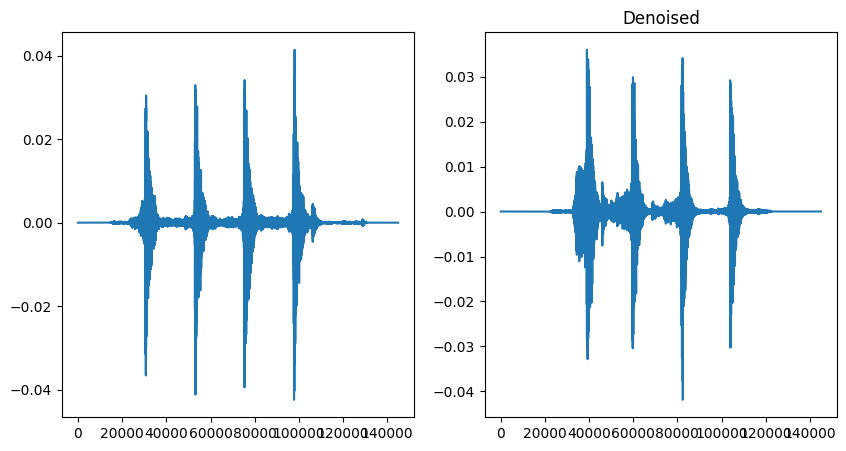

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].plot(clean_sample_1)
axes[1].plot(clean_sample_2)
axes[1].set_title('Denoised')
plt.show()

In [ ]:
print(spectrum.shape)

(401, 722)


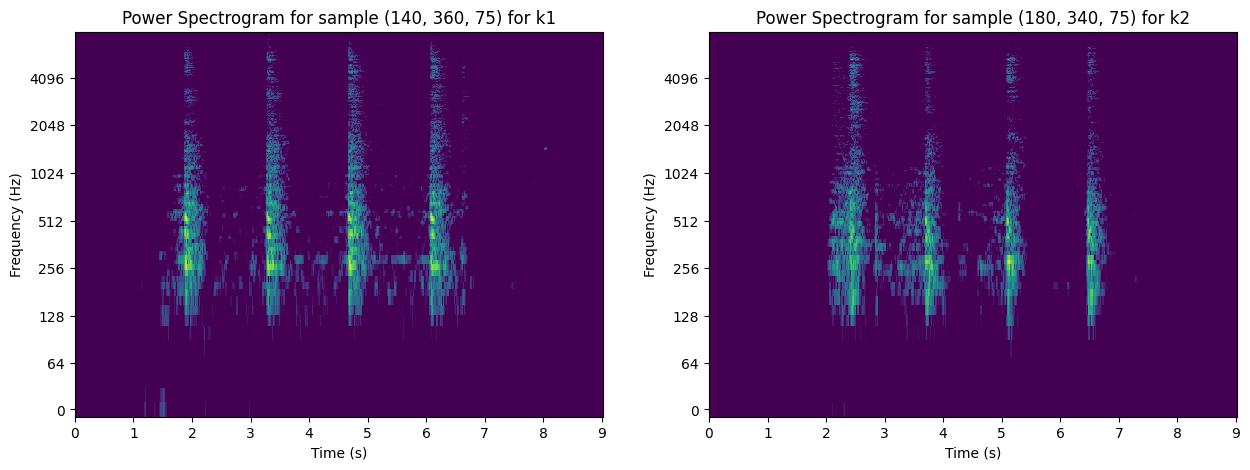

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

# Plot the power spectrogram
librosa.display.specshow(spectrum, sr=sr, hop_length=hop_size, x_axis='time', y_axis='log', cmap='viridis', ax=ax[0])
# fig.colorbar(format='%+2.0f dB')
ax[0].set_title(f'Power Spectrogram for sample {cor1} for k1')
ax[0].set_xlabel('Time (s)')
ax[0].set_ylabel('Frequency (Hz)')

# Plot the power spectrogram
librosa.display.specshow(sec_spectrum, sr=sr, hop_length=hop_size, x_axis='time', y_axis='log', cmap='viridis', ax=ax[1])
# ax[1].set_colorbar(format='%+2.0f dB')
ax[1].set_title(f'Power Spectrogram for sample {cor2} for k2')
ax[1].set_xlabel('Time (s)')
ax[1].set_ylabel('Frequency (Hz)')

plt.show()

In [ ]:
print(np.mean(k2_denoised_data[3], axis=0).shape)

(145000,)


## **Cross Correlogram**

In [ ]:
def adjust_shapes(signal1, signal2):
    max_shape = max(signal1.shape[0], signal2.shape[0])
    signal1 = np.pad(signal1, (max_shape - signal1.shape[0], max_shape - signal1.shape[0]))
    signal2 = np.pad(signal2, (max_shape - signal2.shape[0], max_shape - signal2.shape[0]))
    return signal1, signal2

In [ ]:
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt

def gcc_phat(sig, refsig, fs=16000, max_tau=None, interp=10):
    # Get summation of the shapes of two signals
    n = np.shape(sig)[0] + np.shape(refsig)[0]
    # applies hanning window before DRFFT (discrete real fast fourier transform)
    window = np.hanning(len(sig))
    # applies FFT on both signals and gets the cross power spectral density (CPSD)
    SIG = np.fft.rfft(sig*window, n=n)
    REFSIG = np.fft.rfft(refsig*window, n=n)
    G = SIG * np.conj(REFSIG)
    cc = np.fft.irfft(G / (np.abs(G) + 1e-10), n=(interp * n))
    # where to shift xcorr graph to get negative tau
    shift = int(interp * n / 2)
    if max_tau:
        shift = np.minimum(int(interp * fs * max_tau), shift)
    cc = np.concatenate((cc[-shift:], cc[:shift + 1]))
    # find max cross correlation index
    argmax = np.argmax(cc) - shift
    indices = (np.linspace(0, cc.shape[0], cc.shape[0]) - shift) / float(interp * fs)
    tau = argmax / float(interp * fs)
    return [tau, cc, indices]

In [ ]:
max_tdoa = 6.58892e-4

In [ ]:
cor = (180, 240, 0)
sample = k2_denoised_data[k1_labels.index(cor)][0]
sample2 = k2_denoised_data[k1_labels.index(cor)][1]

In [ ]:
# Adjust length of the signals
sample, sample2 = adjust_shapes(sample, sample2)

frame_size = 800
hop_size = frame_size // 4
sr = 16000

# Calculate the number of frames
num_frames = 1 + int((len(sample) - frame_size) / hop_size)
# Initialize cepstrogram vector
cross_correlogram = np.zeros((421, num_frames))

# Calculatet cepstrum for each frame
for i in range(num_frames):
    start = i * hop_size
    frame1 = sample[start:start + frame_size]
    frame2 = sample2[start:start + frame_size]
    # check for enough frame1 size
    if len(frame1) < frame_size:
        frame1 = np.pad(frame1, (0, frame_size - len(frame1)), 'constant')
    # check for enough frame2 size
    if len(frame2) < frame_size:
        frame2 = np.pad(frame2, (0, frame_size - len(frame2)), 'constant')
    tdoa, cc, lags, = gcc_phat(frame1, frame2, fs=sr, max_tau=max_tdoa, interp=20)
    cross_correlogram[:, i] = cc

print(cross_correlogram.shape)

(421, 722)


In [ ]:
import numpy as np
import librosa
import matplotlib.pyplot as plt

def spectral_subtraction(noisy_spectrogram, noise_estimate):
    # Spectral subtraction formula: clean_spectrum = noisy_spectrum - noise_spectrum
    clean_spectrogram = np.maximum(noisy_spectrogram - noise_estimate, 0)
    return clean_spectrogram

noisy_spectrogram = cross_correlogram  # Your noisy power spectrogram (dB scale)
noise_estimate = np.mean(noisy_spectrogram[:, :], axis=1, keepdims=True)  # Estimate noise from first 10 frames

# Apply Spectral Subtraction
clean_spectrogram = spectral_subtraction(noisy_spectrogram, noise_estimate)

Text(0, 0.5, 'Lag (s)')

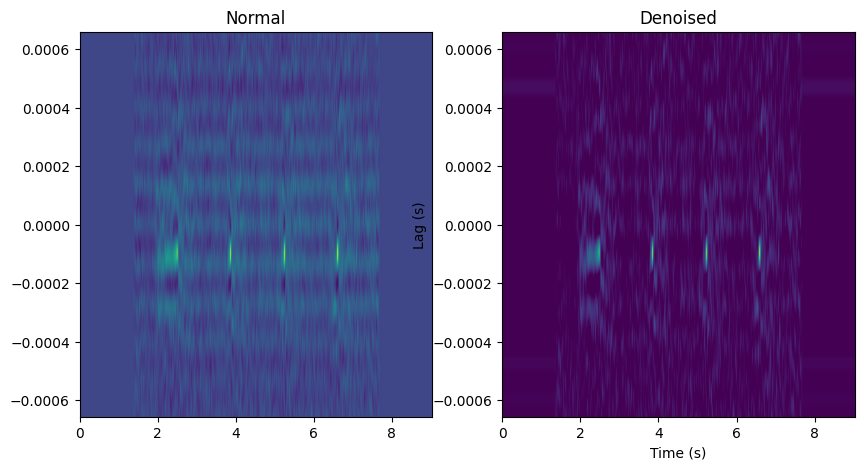

In [ ]:
# Plot the cross-correlogram
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(cross_correlogram, aspect='auto', origin='lower',
           extent=[0, num_frames * hop_size / sr, lags.min(), lags.max()])
axes[0].set_title('Normal')
axes[1].imshow(clean_spectrogram, aspect='auto', origin='lower',
           extent=[0, num_frames * hop_size / sr, lags.min(), lags.max()])
axes[1].set_title('Denoised')
plt.xlabel('Time (s)')
plt.ylabel('Lag (s)')

In [ ]:
print(gcc_phat(sample, sample2, fs=sr, max_tau=max_tdoa)[0])

6.25e-06


## **Generate, Load and Save Cross-Correlograms and Power Spectrums**

In [ ]:
# Parameters for the analysis
frame_size = 800
hop_size = frame_size // 4
interpolation = 20
sr = 16000
max_tdoa = 6.58892e-4

### **The first function is going to generate the power spectrum for each sample. For each sample, we'll generate the power spectrum for each channel.**

In [ ]:
def get_spectrum(sample, frame_size, hop_size):
    # Compute the Short-Time Fourier Transform (STFT)
    stft = librosa.stft(sample, n_fft=frame_size, hop_length=hop_size, center=False)
    # Compute the power spectrogram (squared magnitude of the STFT)
    power_spectrogram = np.abs(stft)**2
    power_spectrogram_db = librosa.amplitude_to_db(power_spectrogram, ref=np.max)
    return power_spectrogram_db

In [ ]:
def generate_power_spectrums(raw_data, frame_size, hop_size, idx, labels):
    print(f'\n******\nAt K{idx}\n*****\n')
    power_spectrums = []
    for i in range(len(raw_data)):
        print(f'At sample {labels[i]}', end='-')
        power_specs = []
        for j in range(raw_data[i].shape[0]):
            power_specs.append(get_spectrum(raw_data[i][j], frame_size, hop_size))
        power_spectrums.append(power_specs)
    return np.array(power_spectrums)

In [ ]:
power_spectrums_k1 = generate_power_spectrums(k1_denoised_data, frame_size, hop_size, 1, k1_labels)
power_spectrums_k2 = generate_power_spectrums(k2_denoised_data, frame_size, hop_size, 2, k2_labels)
power_spectrums_k3 = generate_power_spectrums(k3_denoised_data, frame_size, hop_size, 3, k3_labels)

print(power_spectrums_k1.shape)
print(power_spectrums_k2.shape)
print(power_spectrums_k3.shape)


******
At K1
*****

At sample (0, 0, 0)-At sample (20, 0, 0)-At sample (40, 0, 0)-At sample (60, 0, 0)-At sample (80, 0, 0)-At sample (100, 0, 0)-At sample (120, 0, 0)-At sample (140, 0, 0)-At sample (160, 0, 0)-At sample (180, 0, 0)-At sample (200, 0, 0)-At sample (220, 0, 0)-At sample (240, 0, 0)-At sample (260, 0, 0)-At sample (280, 0, 0)-At sample (0, 20, 0)-At sample (20, 20, 0)-At sample (40, 20, 0)-At sample (60, 20, 0)-At sample (80, 20, 0)-At sample (100, 20, 0)-At sample (120, 20, 0)-At sample (140, 20, 0)-At sample (160, 20, 0)-At sample (180, 20, 0)-At sample (200, 20, 0)-At sample (220, 20, 0)-At sample (240, 20, 0)-At sample (260, 20, 0)-At sample (280, 20, 0)-At sample (0, 40, 0)-At sample (20, 40, 0)-At sample (40, 40, 0)-At sample (60, 40, 0)-At sample (80, 40, 0)-At sample (100, 40, 0)-At sample (120, 40, 0)-At sample (140, 40, 0)-At sample (160, 40, 0)-At sample (180, 40, 0)-At sample (200, 40, 0)-At sample (220, 40, 0)-At sample (240, 40, 0)-At sample (260, 40, 0)-

### **Save and Load Power Spectrums**

In [ ]:
import pickle

# save cross correlograms labels
path = '/content/drive/MyDrive/Taarlab/Classical/Main/3kinects/Power Spectrums'
with open(path + '/power_spectrums_k1.pkl', 'wb') as file:
    pickle.dump(power_spectrums_k1, file)
print("K1 Spectrums saved to file successfully.")

# save cross correlograms labels
path = '/content/drive/MyDrive/Taarlab/Classical/Main/3kinects/Power Spectrums'
with open(path + '/power_spectrums_k2.pkl', 'wb') as file:
    pickle.dump(power_spectrums_k2, file)
print("K2 Spectrums saved to file successfully.")

# save cross correlograms labels
path = '/content/drive/MyDrive/Taarlab/Classical/Main/3kinects/Power Spectrums'
with open(path + '/power_spectrums_k3.pkl', 'wb') as file:
    pickle.dump(power_spectrums_k3, file)
print("K3 Spectrums saved to file successfully.")

# save cross correlograms labels
path = '/content/drive/MyDrive/Taarlab/Classical/Main/3kinects/Power Spectrums'
with open(path + '/labels.pkl', 'wb') as file:
    pickle.dump(k1_labels, file)
print("Labels saved to file successfully.")

K1 Spectrums saved to file successfully.
K2 Spectrums saved to file successfully.
K3 Spectrums saved to file successfully.
Labels saved to file successfully.


In [ ]:
# load labels from files
path = '/content/drive/MyDrive/Taarlab/Classical/Main/2Kinects/DeepNet Samples/power-spectrums/K2'
with open(path + '/labels.pkl', 'rb') as file:
    labels_k2 = pickle.load(file)
print("Raw K2 labels loaded from file successfully.")
# load cross correlograms from file
power_spectrums_k2 = np.load(path + '/power_spectrums_k2.npy')
print('K2 Power Spectrums loaded from file successfully.')

# print(power_spectrums_k1.shape, np.array(labels_k1).shape)
print(power_spectrums_k2.shape, np.array(labels_k2).shape)

Raw K2 labels loaded from file successfully.
K2 Power Spectrums loaded from file successfully.
(57, 4, 401, 674) (57, 3)


## **Generate Phase Spectrums**

In [ ]:
def get_phase_spectrum(sample, frame_size, hop_size):
    # Compute the Short-Time Fourier Transform (STFT)
    stft = librosa.stft(sample, n_fft=frame_size, hop_length=hop_size, center=False)
    # Compute the power spectrogram (squared magnitude of the STFT)
    phase_spectrum = np.angle(stft)
    return phase_spectrum

In [ ]:
def generate_phase_spectrums(raw_data, frame_size, hop_size, idx, labels):
    print(f'\n******\nAt K{idx}\n*****\n')
    phase_spectrums = []
    for i in range(len(raw_data)):
        print(f'At sample {labels[i]}', end='-')
        phase_specs = []
        for j in range(raw_data[i].shape[0]):
            clean_sample = spectral_subtraction(raw_data[i][j])
            phase_specs.append(get_phase_spectrum(clean_sample, frame_size, hop_size))
        phase_specs = np.array(phase_specs)
        phase_spectrums.append(np.mean(phase_specs, axis=0))
    return np.array(phase_spectrums)

In [ ]:
# power_spectrums_k1 = generate_power_spectrums(k1_denoised_data, frame_size, hop_size, 1, k1_labels)
phase_spectrums_k2 = generate_phase_spectrums(k2_denoised_data, frame_size, hop_size, 2, k2_labels)
phase_spectrums_k3 = generate_phase_spectrums(k3_denoised_data, frame_size, hop_size, 3, k3_labels)

# print(phase_spectrums_k1.shape)
print(phase_spectrums_k2.shape)
print(phase_spectrums_k3.shape)


******
At K2
*****

At sample (0, 0, 0)-At sample (20, 0, 0)-At sample (40, 0, 0)-At sample (60, 0, 0)-At sample (80, 0, 0)-At sample (100, 0, 0)-At sample (120, 0, 0)-At sample (140, 0, 0)-At sample (160, 0, 0)-At sample (180, 0, 0)-At sample (200, 0, 0)-At sample (220, 0, 0)-At sample (240, 0, 0)-At sample (260, 0, 0)-At sample (280, 0, 0)-At sample (0, 20, 0)-At sample (20, 20, 0)-At sample (40, 20, 0)-At sample (60, 20, 0)-At sample (80, 20, 0)-At sample (100, 20, 0)-At sample (120, 20, 0)-At sample (140, 20, 0)-At sample (160, 20, 0)-At sample (180, 20, 0)-At sample (200, 20, 0)-At sample (220, 20, 0)-At sample (240, 20, 0)-At sample (260, 20, 0)-At sample (280, 20, 0)-At sample (0, 40, 0)-At sample (20, 40, 0)-At sample (40, 40, 0)-At sample (60, 40, 0)-At sample (80, 40, 0)-At sample (100, 40, 0)-At sample (120, 40, 0)-At sample (140, 40, 0)-At sample (160, 40, 0)-At sample (180, 40, 0)-At sample (200, 40, 0)-At sample (220, 40, 0)-At sample (240, 40, 0)-At sample (260, 40, 0)-

### **Save and Load Phase Spectrums**

In [ ]:
import pickle

# save cross correlograms labels
# path = '/content/drive/MyDrive/Taarlab/Classical/Main/3kinects/Power Spectrums'
# with open(path + '/power_spectrums_k1.pkl', 'wb') as file:
#     pickle.dump(power_spectrums_k1, file)
# print("K1 Spectrums saved to file successfully.")

# save cross correlograms labels
path = '/content/drive/MyDrive/Taarlab/Classical/Main/3kinects/Phase Spectrums'
with open(path + '/phase_spectrums_k2.pkl', 'wb') as file:
    pickle.dump(phase_spectrums_k2, file)
print("K2 Spectrums saved to file successfully.")

# save cross correlograms labels
with open(path + '/phase_spectrums_k3.pkl', 'wb') as file:
    pickle.dump(phase_spectrums_k3, file)
print("K3 Spectrums saved to file successfully.")

# save cross correlograms labels
with open(path + '/labels.pkl', 'wb') as file:
    pickle.dump(k1_labels, file)
print("Labels saved to file successfully.")

K2 Spectrums saved to file successfully.
K3 Spectrums saved to file successfully.
Labels saved to file successfully.


In [ ]:
# load labels from files
path = '/content/drive/MyDrive/Taarlab/Classical/Main/2Kinects/DeepNet Samples/power-spectrums/K2'
with open(path + '/labels.pkl', 'rb') as file:
    labels_k2 = pickle.load(file)
print("Raw K2 labels loaded from file successfully.")
# load cross correlograms from file
power_spectrums_k2 = np.load(path + '/power_spectrums_k2.npy')
print('K2 Power Spectrums loaded from file successfully.')

# print(power_spectrums_k1.shape, np.array(labels_k1).shape)
print(power_spectrums_k2.shape, np.array(labels_k2).shape)

Raw K2 labels loaded from file successfully.
K2 Power Spectrums loaded from file successfully.
(57, 4, 401, 674) (57, 3)


### **Now, below is the functions for generating the cross-correlograms.**

In [ ]:
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt

def gcc_phat(sig, refsig, fs=16000, max_tau=6.58892e-4, interp=20):
    # Get summation of the shapes of two signals
    n = np.shape(sig)[0] + np.shape(refsig)[0]
    # applies hanning window before DRFFT (discrete real fast fourier transform)
    window = np.hanning(len(sig))
    # applies FFT on both signals and gets the cross power spectral density (CPSD)
    SIG = np.fft.rfft(sig*window, n=n)
    REFSIG = np.fft.rfft(refsig*window, n=n)
    G = SIG * np.conj(REFSIG)
    cc = np.fft.irfft(G / (np.abs(G) + 1e-10), n=(interp * n))
    # where to shift xcorr graph to get negative tau
    shift = int(interp * n / 2)
    if max_tau:
        shift = np.minimum(int(interp * fs * max_tau), shift)
    cc = np.concatenate((cc[-shift:], cc[:shift + 1]))
    # find max cross correlation index
    argmax = np.argmax(cc) - shift
    indices = (np.linspace(0, cc.shape[0], cc.shape[0]) - shift) / float(interp * fs)
    tau = argmax / float(interp * fs)
    return [tau, cc, indices]

In [ ]:
def adjust_shapes(signal1, signal2):
    max_shape = max(signal1.shape[0], signal2.shape[0])
    signal1 = np.pad(signal1, (max_shape - signal1.shape[0], max_shape - signal1.shape[0]))
    signal2 = np.pad(signal2, (max_shape - signal2.shape[0], max_shape - signal2.shape[0]))
    return signal1, signal2

In [ ]:
def get_correlogram(sig, refsig, sr, frame_size, hop_size, interpolation, max_tdoa):
    # Adjust length of the signals
    sig, refsig = adjust_shapes(sig, refsig)
    # Calculate the number of frames
    num_frames = 1 + int((len(sig) - frame_size) / hop_size)
    lags_res = 1 / (interpolation * sr)
    lags_num = int((2 * max_tdoa) / lags_res)
    # Initialize cepstrogram vector
    cross_correlogram = np.zeros((lags_num, num_frames))
    # Calculatet correlogram for each frame
    for i in range(num_frames):
        start = i * hop_size
        frame1 = sig[start:start + frame_size]
        frame2 = refsig[start:start + frame_size]
        # check for enough frame1 size
        if len(frame1) < frame_size:
            frame1 = np.pad(frame1, (0, frame_size - len(frame1)), 'constant')
        # check for enough frame2 size
        if len(frame2) < frame_size:
            frame2 = np.pad(frame2, (0, frame_size - len(frame2)), 'constant')
        tdoa, cc, lags, = gcc_phat(frame1, frame2, fs=sr, max_tau=max_tdoa, interp=interpolation)
        cross_correlogram[:, i] = cc
    return cross_correlogram

In [ ]:
def generate_cross_correlograms(raw_data, labels, idx, frame_size, hop_size, interpolation, max_tdoa, sr):
    cross_correlograms = []
    print(f'\n\n>>>>>> At k{idx}:')
    for i in range(len(raw_data)):
        correlograms = []
        num_of_ch = raw_data[i].shape[0]
        for j in range(0, num_of_ch):
            for z in range(j+1, num_of_ch):
                sig = raw_data[i][j]
                refsig = raw_data[i][z]
                cross_corr = get_correlogram(sig, refsig, sr, frame_size, hop_size, interpolation, max_tdoa)
                noise_estimate = np.mean(cross_corr[:, :], axis=1, keepdims=True)
                cleaned_corr = spectral_subtraction(cross_corr, noise_estimate)
                correlograms.append(cleaned_corr)
        cross_correlograms.append(correlograms)
        print(f' Sample {labels[i]} done.', end=' -')
    return np.array(cross_correlograms)

In [ ]:
cross_correlograms_k1 = generate_cross_correlograms(k1_denoised_data, k1_labels, 1, frame_size, hop_size, interpolation, max_tdoa, sr)
cross_correlograms_k2 = generate_cross_correlograms(k2_denoised_data, k1_labels, 2, frame_size, hop_size, interpolation, max_tdoa, sr)
cross_correlograms_k3 = generate_cross_correlograms(k3_denoised_data, k1_labels, 3, frame_size, hop_size, interpolation, max_tdoa, sr)



>>>>>> At k1:


/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=722
  warnings.warn(


In [ ]:
print(cross_correlogram_k1.shape)
print(cross_correlogram_k2.shape)
print(cross_correlogram_k3.shape)

In [ ]:
print(cross_correlograms.shape)

(57, 6, 1055, 674)


### **Save and Load Cross Correlograms**

In [ ]:
import pickle

# save cross correlograms labels
path = '/content/drive/MyDrive/Taarlab/Classical/Main/3kinects/Cross Correlograms'
with open(path + '/cross_correlograms_k1.pkl', 'wb') as file:
    pickle.dump(cross_correlograms_k1, file)
print("K1 correlograms saved to file successfully.")

K2 Raw Labels saved to file successfully.
Cross Correlograms of K2 saved to npy file successfully.


In [ ]:
# save cross correlograms labels
path = '/content/drive/MyDrive/Taarlab/Classical/Main/3kinects/Cross Correlograms'
with open(path + '/cross_correlograms_k2.pkl', 'wb') as file:
    pickle.dump(cross_correlograms_k2, file)
print("K2 correlograms saved to file successfully.")

In [ ]:
# save cross correlograms labels
path = '/content/drive/MyDrive/Taarlab/Classical/Main/3kinects/Cross Correlograms'
with open(path + '/cross_correlograms_k3.pkl', 'wb') as file:
    pickle.dump(cross_correlograms_k3, file)
print("K3 correlograms saved to file successfully.")

In [ ]:
import pickle
import numpy as np

# load labels from files
path = '/content/drive/MyDrive/Taarlab/Classical/Main/2Kinects/DeepNet Samples/cross-correlograms/K2'
with open(path + '/labels.pkl', 'rb') as file:
    labels_k2 = pickle.load(file)
print("Raw K2 labels loaded from file successfully.")
# load cross correlograms from file
cross_correlograms_k2 = np.load(path + '/cross_correlograms_k2.npy')
print('K2 Cross Correlograms loaded from file successfully.')

# print(cross_correlograms_k1.shape, np.array(labels_k1).shape)
print(cross_correlograms_k2.shape, np.array(labels_k2).shape)

Raw K2 labels loaded from file successfully.
K2 Cross Correlograms loaded from file successfully.
(57, 6, 1055, 674) (57, 3)


## **Model and Training Process**

### **Review of Model**

This model is used in a sound source localization application in australlia in which the sound source is a boat motor vessel under a shallow water surface. The below is the structure of the proposed model:

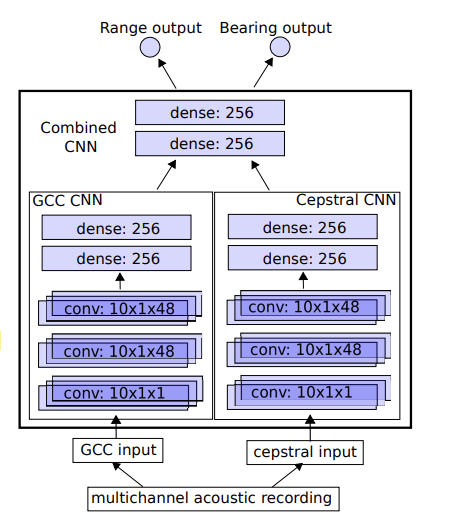

### **Training**

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

def get_CNN_parallel_model(cc_input_shape, ps_input_shape, summary=False):
    # GCC CNN model
    input_gcc = tf.keras.Input(shape=cc_input_shape)
    # First Convolutional Layer
    x1 = layers.Conv2D(10, (10, 10), activation='relu')(input_gcc)
    x1 = layers.MaxPooling2D(pool_size=(5, 5))(x1)
    # Second Convolutional Layer
    x1 = layers.Conv2D(10, (7, 7), activation='relu')(x1)
    x1 = layers.MaxPooling2D(pool_size=(3, 3))(x1)
    # Third Convolutional Layer
    x1 = layers.Conv2D(10, (5, 5), activation='relu')(x1)
     # Flatten the output
    x1 = layers.Flatten()(x1)
    # Dense layers for GCC branch
    x1 = layers.Dense(256, activation='relu')(x1)
    x1 = layers.Dense(256, activation='relu')(x1)

    # Power Spectrum CNN model
    input_ps = tf.keras.Input(shape=ps_input_shape)
    # First Convolutional Layer
    x2 = layers.Conv2D(10, (10, 10), activation='relu')(input_ps)
    x2 = layers.MaxPooling2D(pool_size=(3, 3))(x2)
    # Second Convolutional Layer
    x2 = layers.Conv2D(10, (7, 7), activation='relu')(x2)
    x2 = layers.MaxPooling2D(pool_size=(2, 2))(x2)
    # Third Convolutional Layer
    x2 = layers.Conv2D(10, (5, 5), activation='relu')(x2)
    # Flatten the output
    x2 = layers.Flatten()(x2)
    # Dense layers for Power Spectrum branch
    x2 = layers.Dense(256, activation='relu')(x2)
    x2 = layers.Dense(256, activation='relu')(x2)

    # Concatenate the outputs of the two branches
    concatenated = layers.Concatenate()([x1, x2])
    # Fully connected layers after concatenation
    x = layers.Dense(256, activation='relu')(concatenated)
    x = layers.Dense(256, activation='relu')(x)
    # Output layer with 3 nodes (e.g., for classification)
    output = layers.Dense(3, activation='linear')(x)

    # Define the model with two inputs
    model = models.Model(inputs=[input_gcc, input_ps], outputs=output)
    if summary:
        model.summary()
    return model

In [ ]:
from sklearn.model_selection import train_test_split

# split the gcc cross correlations
cc_splitted_train, cc_splitted_test, labels_k2_train, labels_k2_test = train_test_split(cross_correlograms_k2, labels_k2, test_size=10)
cc_splitted_train, cc_splitted_val, labels_k2_train, labels_k2_val = train_test_split(cc_splitted_train, labels_k2_train, test_size=6)
cc_splitted_train = cc_splitted_train.transpose((0, 2, 3, 1))
cc_splitted_test = cc_splitted_test.transpose((0, 2, 3, 1))
cc_splitted_val = cc_splitted_val.transpose((0, 2, 3, 1))
print(cc_splitted_train.shape, cc_splitted_test.shape, cc_splitted_val.shape)

train_indexes = [labels_k2.index(lbl) for lbl in labels_k2_train]
val_indexes = [labels_k2.index(lbl) for lbl in labels_k2_val]
test_indexes = [labels_k2.index(lbl) for lbl in labels_k2_test]

# split the power spectrums
ps_splitted_train = np.array([power_spectrums_k2[i] for i in train_indexes])
ps_splitted_val = np.array([power_spectrums_k2[i] for i in val_indexes])
ps_splitted_test = np.array([power_spectrums_k2[i] for i in test_indexes])
ps_splitted_train = ps_splitted_train.transpose((0, 2, 3, 1))
ps_splitted_val = ps_splitted_val.transpose((0, 2, 3, 1))
ps_splitted_test = ps_splitted_test.transpose((0, 2, 3, 1))
print(ps_splitted_train.shape, ps_splitted_test.shape, ps_splitted_val.shape)

(41, 1055, 674, 6) (10, 1055, 674, 6) (6, 1055, 674, 6)
(41, 401, 674, 4) (10, 401, 674, 4) (6, 401, 674, 4)


In [ ]:
# create X and y
X_train = [cc_splitted_train, ps_splitted_train]
y_train = np.array(labels_k2_train)
y_train_xy = np.array([(x, y) for (x, y, z) in y_train])
X_val = [cc_splitted_val, ps_splitted_val]
y_val = np.array(labels_k2_val)
y_val_xy = np.array([(x, y) for (x, y, z) in y_val])
X_test = [cc_splitted_test, ps_splitted_test]
y_test = np.array(labels_k2_test)
y_test_xy = np.array([(x, y) for (x, y, z) in y_test])

In [ ]:
# specify input size
inp_gcc = cc_splitted_train[0].shape
inp_ps = ps_splitted_train[0].shape

print(inp_gcc, inp_ps)

(1055, 674, 6) (401, 674, 4)


In [ ]:
# define model
cur_model = get_CNN_parallel_model(inp_gcc, inp_ps, summary=True)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 1055, 674, 6)   │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_1             │ (None, 401, 674, 4)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 1046, 665, 10)  │          6,010 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 392, 665, 10)   │          4,010 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 209, 133, 10)   │              0 │ conv2d[0][0]           │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 130, 221, 10)   │              0 │ conv2d_3[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 203, 127, 10)   │          4,910 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 124, 215, 10)   │          4,910 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 67, 42, 10)     │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_3           │ (None, 62, 107, 10)    │              0 │ conv2d_4[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 63, 38, 10)     │          2,510 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 58, 103, 10)    │          2,510 │ max_pooling2d_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 23940)          │              0 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_1 (Flatten)       │ (None, 59740)          │              0 │ conv2d_5[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 256)            │      6,128,896 │ flatten[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 256)            │     15,293,696 │ flatten_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 256)            │         65,792 │ dense[0][0]            │
├──────────────────────

 Total params: 21,776,927 (83.07 MB)

 Trainable params: 21,776,927 (83.07 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from keras.callbacks import EarlyStopping

# Compile the model
cur_model.compile(optimizer='adam', loss='mean_absolute_error', metrics=['mean_absolute_error'])

early_stop = EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=100,
    mode="auto",
    baseline=None,
    restore_best_weights=False,
    start_from_epoch=0,
)

# train the model
train_hist = cur_model.fit(x=X_train, y=y_train, epochs=500, batch_size=8, validation_data=(X_val, y_val), callbacks=[early_stop])
hist = train_hist

Epoch 1/500
6/6 ━━━━━━━━━━━━━━━━━━━━ 11s 805ms/step - loss: 99.3699 - mean_absolute_error: 99.3699 - val_loss: 76.2305 - val_mean_absolute_error: 76.2305
Epoch 2/500
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 246ms/step - loss: 97.6152 - mean_absolute_error: 97.6152 - val_loss: 99.2655 - val_mean_absolute_error: 99.2655
Epoch 3/500
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 254ms/step - loss: 90.8918 - mean_absolute_error: 90.8918 - val_loss: 74.4760 - val_mean_absolute_error: 74.4760
Epoch 4/500
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 247ms/step - loss: 80.9526 - mean_absolute_error: 80.9526 - val_loss: 91.0483 - val_mean_absolute_error: 91.0483
Epoch 5/500
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 297ms/step - loss: 68.2478 - mean_absolute_error: 68.2478 - val_loss: 123.6963 - val_mean_absolute_error: 123.6963
Epoch 6/500
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 301ms/step - loss: 74.8190 - mean_absolute_error: 74.8190 - val_loss: 76.5394 - val_mean_absolute_error: 76.5394
Epoch 7/500
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 281ms/step - loss: 68.0812 - mean_absol

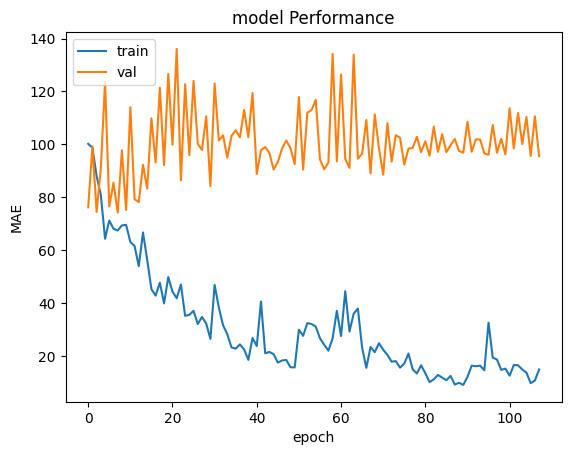

In [ ]:
import matplotlib.pyplot as plt

plt.plot(hist.history['mean_absolute_error'])
plt.plot(hist.history['val_mean_absolute_error'])
plt.title('model Performance')
plt.ylabel('MAE')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
import math

def calculate_test_error(model, X_test, y_test, euclidean = True):
    predicted_raw_labels = model.predict(X_test)
    mae_error = []
    for i in range(len(predicted_raw_labels)):
        mae_error.append(abs(predicted_raw_labels[i][0] - y_test[i][0]) + abs(predicted_raw_labels[i][1] - y_test[i][1]) + abs(predicted_raw_labels[i][2] - y_test[i][2]))
    if euclidean:
        euc_error = []
        for i in range(len(predicted_raw_labels)):
            euc_error.append(math.sqrt((predicted_raw_labels[i][0] - y_test[i][0])**2 + (predicted_raw_labels[i][1] - y_test[i][1])**2 + (predicted_raw_labels[i][2] - y_test[i][2])**2))
        return mae_error, np.array(mae_error).mean(), euc_error, np.array(euc_error).mean()
    return mae_error, np.array(mae_error).mean()

In [ ]:
mae_errors, mean_mae_error, euc_errors, mean_euc_error = calculate_test_error(cur_model, X_test, y_test, euclidean=True)

print('Mean MAE error:', mean_mae_error)
print('Mean EUC error:', mean_euc_error)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 670ms/step
Mean MAE error: 259.6996380805969
Mean EUC error: 189.45368283812294


In [ ]:
print(y_train)

[[100 193   0]
 [130 340  74]
 [207 382  74]
 [227 392   0]
 [171 328   0]
 [ 62 124   0]
 [102   6   0]
 [190 360  74]
 [173  69   0]
 [200 395  74]
 [277   5   0]
 [232 189   0]
 [141  27   0]
 [140 394  74]
 [272 188   0]
 [142  84   0]
 [221  70   0]
 [115  69   0]
 [146 154   0]
 [ 54 188   0]
 [140 227   0]
 [170 380  74]
 [137 193   0]
 [210 360  74]
 [176  27   0]
 [275 394   0]
 [206 337  74]
 [160 340  74]
 [175 395  74]
 [ 75 395  74]
 [225 334   0]
 [140 314   0]
 [ 56 338   0]
 [100 340  74]
 [ 74 363  74]
 [  4 192   0]
 [ 75 385  74]
 [ 60   4   0]
 [ 58 280   0]
 [120 380  74]
 [126 208   0]]


In [ ]:
print(cur_model.predict(X_train))

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 359ms/step
[[ 9.59189682e+01  1.64386551e+02 -1.78795481e+00]
 [ 1.17125320e+02  3.03625183e+02  6.52285767e+01]
 [ 1.89837128e+02  3.33072632e+02  7.49648743e+01]
 [ 1.99886429e+02  3.38097961e+02 -3.81832361e+00]
 [ 1.71754288e+02  2.84567810e+02 -1.75868273e+00]
 [ 6.56683960e+01  1.18222603e+02 -2.38287941e-01]
 [ 1.10847466e+02 -6.05731010e+00 -1.38269067e+00]
 [ 1.89183563e+02  3.27471558e+02  7.82258072e+01]
 [ 1.80558380e+02  5.30739670e+01 -3.47797424e-01]
 [ 1.78429321e+02  3.47462219e+02  7.09133072e+01]
 [ 2.67640778e+02 -1.75865669e+01 -1.12458706e+00]
 [ 2.35901947e+02  1.36950089e+02 -5.77388287e-01]
 [ 1.35732376e+02  2.01463890e+01 -6.82537779e-02]
 [ 1.10980293e+02  4.03726135e+02  7.62552567e+01]
 [ 2.99884491e+02  7.31336288e+01 -1.13910221e-01]
 [ 1.41128220e+02  6.54900436e+01 -2.91411906e-01]
 [ 2.14414200e+02  4.46358032e+01 -3.38835269e-01]
 [ 1.13359962e+02  5.67759666e+01 -4.26140577e-01]
 [ 1.41195297e+02  1.18852242e+02 -6.040554

## **Results Visualization Functions**

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

k2_mic_pos = [
        [282, 211.3, 75],
        [282, 196.4, 75],
        [282, 192.4, 75],
        [282, 188.7, 75]
    ]

k1_mic_pos = [
    [152.3, 0, 77],
    [137.4, 0, 75],
    [133.4, 0, 74],
    [129.7, 0, 74]
]

# Environment traits
mins = (0, 0, 0)
maxs = (282, 400, 75)
grid_resolution = 1
table_start = 330
table_end = 400

# Microphone positions in 3D
mics_k1 = k1_mic_pos
mics_k2 = k2_mic_pos

microphone_xs_k1 = [sublist[0] for sublist in mics_k1]
microphone_ys_k1 = [sublist[1] for sublist in mics_k1]
microphone_zs_k1 = [sublist[2] for sublist in mics_k1]

microphone_xs_k2 = [sublist[0] for sublist in mics_k2]
microphone_ys_k2 = [sublist[1] for sublist in mics_k2]
microphone_zs_k2 = [sublist[2] for sublist in mics_k2]

# Extract margins
x_min, y_min, z_min = mins
x_max, y_max, z_max = maxs
table_y_min = 330
table_y_max = 400
table_x_min = 70
table_x_max = 210
table_z = 75


def plot_points(positions, predicted, pred_dict, num_of_mics, has_z=True, plot_refined=False):
    # Example lists of positions
    actual_positions = positions
    predicted_positions = predicted
    # refined_predicted_positions = refined

    # mic positions
    mic_xs = (microphone_xs_k1, microphone_xs_k2)
    mic_ys = (microphone_ys_k1, microphone_ys_k2)
    mic_zs = (microphone_zs_k1, microphone_zs_k2)

    # Create a 3D plot
    fig = plt.figure(figsize=(15, 9))
    ax = fig.add_subplot(111, projection='3d')

    # Unpack the positions for plotting
    actual_x, actual_y, actual_z = zip(*actual_positions)
    if not has_z:
        predicted_x, predicted_y = zip(*predicted_positions)
        predicted_z = actual_z
    else:
        predicted_x, predicted_y, predicted_z = zip(*predicted_positions)
    # refined_x, refined_y, refined_z = zip(*refined_predicted_positions)

    # Plot the points
    ax.scatter(actual_x, actual_y, actual_z, c='r', marker='o', label='Actual')
    ax.scatter(predicted_x, predicted_y, predicted_z, c='b', marker='^', label='Predicted')
    if plot_refined:
        ax.scatter(refined_x, refined_y, refined_z, c='g', marker='s', label='Refined Predicted')

    # Connect the actual points to predicted and refined predicted points
    for i in range(len(actual_positions)):
        ax.plot([actual_x[i], predicted_x[i]], [actual_y[i], predicted_y[i]], [actual_z[i], predicted_z[i]], c='b', linestyle='dashed')
        if plot_refined:
            ax.plot([actual_x[i], refined_x[i]], [actual_y[i], refined_y[i]], [actual_z[i], refined_z[i]], c='g', linestyle='dotted')

    # Plot microphone points
    if num_of_mics == 1:
        ax.scatter(mic_xs[0], mic_ys[0], mic_zs[0], marker='s', c='purple', label='Microhpones')
        for j in range(len(microphone_xs_k1)):
            ax.plot([mic_xs[0][j], mic_xs[0][j]], [mic_ys[0][j], mic_ys[0][j]], [mic_zs[0][j], 0], c='purple', linestyle='solid')
    elif num_of_mics == 2:
        ax.scatter(mic_xs[1], mic_ys[1], mic_zs[1], marker='s', c='purple', label='Microhpones')
        for j in range(len(microphone_xs_k2)):
            ax.plot([mic_xs[1][j], mic_xs[1][j]], [mic_ys[1][j], mic_ys[1][j]], [mic_zs[1][j], 0], c='purple', linestyle='solid')
    elif num_of_mics == 3:
        ax.scatter(mic_xs, mic_ys, mic_zs, marker='s', c='purple', label='Microhpones')
        for i in range(num_of_mics - 1):
            for j in range(len(microphone_xs_k1)):
                ax.plot([mic_xs[i][j], mic_xs[i][j]], [mic_ys[i][j], mic_ys[i][j]], [mic_zs[i][j], 0], c='purple', linestyle='solid')

    # Set grid dimensions
    ax.set_xlim([x_min, x_max])
    ax.set_ylim([y_min, y_max])
    ax.set_zlim([z_min, z_max])

    # Highlight the table range horizontally with 3D polygons
    table_vertices = [
        [(table_x_min, table_y_min, 0), (table_x_max, table_y_min, 0), (table_x_max, table_y_min, table_z), (table_x_min, table_y_min, table_z)],
        [(table_x_min, table_y_min, table_z), (table_x_max, table_y_min, table_z), (table_x_max, table_y_max, table_z), (table_x_min, table_y_max, table_z)]
    ]

    ax.add_collection3d(Poly3DCollection(table_vertices, color='gray', alpha=0.3))

    # Label the axes
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

    # Add legend
    ax.legend()

    # Show the plot
    plt.show()

In [ ]:
import math
NOT_VALID = -1

def calculate_error(pred_dict, has_z=True):
    errors_pred = {
        'er_x': [],
        'er_y': [],
        'er_z': [],
        'total_errors': []
    }
    # Calculate error for preds
    for actual_pos, pred in pred_dict.items():
        if len(actual_pos) != len(pred):
            return NOT_VALID
        else:
            if has_z:
                x_final, y_final, z_final = pred
                errors_pred['er_x'].append(abs((actual_pos[0] - x_final)))
                errors_pred['er_y'].append(abs((actual_pos[1] - y_final)))
                errors_pred['er_z'].append(abs((actual_pos[2] - z_final)))
                errors_pred['total_errors'].append(math.sqrt((actual_pos[0] - x_final)**2 + (actual_pos[1] - y_final)**2 + (actual_pos[2] - z_final)**2))
            elif not has_z:
                x_final, y_final = pred
                errors_pred['er_x'].append(abs((actual_pos[0] - x_final)))
                errors_pred['er_y'].append(abs((actual_pos[1] - y_final)))
                errors_pred['total_errors'].append(math.sqrt((actual_pos[0] - x_final)**2 + (actual_pos[1] - y_final)**2))

    # Calculate means for preds
    means_pred = {}
    for er_name, errors in errors_pred.items():
        mean = np.mean(errors)
        means_pred['mean_of_' + er_name + ' for prediction'] = mean
    if not has_z:
        means_pred['mean_of_' + 'er_z' + ' for prediction'] = 'Unvalid'
    return means_pred

In [ ]:
def average_predictions(predicted, actual_labels):
    pred_dict = {}
    for label in actual_labels.tolist():
        pred_dict[tuple(label)] = []
    for i in range(len(predicted)):
        pred_dict[tuple(actual_labels[i])].append(predicted[i].tolist())
    for key in pred_dict.keys():
        pred_dict[key] = np.mean(pred_dict[key], axis=0).tolist()
    return list(pred_dict.keys()), list(pred_dict.values()), pred_dict

In [ ]:
def extract_unique_lists(two_dim_list):
    seen = set()
    unique_lists = []

    for sublist in two_dim_list:
        # Convert the sublist to a tuple so it can be added to a set
        sublist_tuple = tuple(sublist)

        # If the tuple is not in the seen set, add it
        if sublist_tuple not in seen:
            seen.add(sublist_tuple)
            unique_lists.append(sublist.tolist())

    return unique_lists

## **Results Visualization**

In [ ]:
predicted_raw_labels = cur_model.predict(X_test)
print(len(predicted_raw_labels))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step
10


In [ ]:
actuals, predictions, pred_dict = average_predictions(predicted_raw_labels, y_test)
means_pred = calculate_error(pred_dict, has_z=True)

In [ ]:
print(extract_unique_lists(y_test))
print(pred_dict)

[[109, 327, 0], [190, 340, 74], [61, 60, 0], [150, 360, 74], [8, 392, 0], [184, 6, 0], [105, 395, 74], [185, 191, 0], [54, 393, 0], [107, 358, 74]]
{(109, 327, 0): [134.52584838867188, 247.0849151611328, 28.132280349731445], (190, 340, 74): [93.62518310546875, 196.27203369140625, -6.706451892852783], (61, 60, 0): [27.546157836914062, 163.9690704345703, 1.963731288909912], (150, 360, 74): [104.36454772949219, 224.72671508789062, 43.083984375], (8, 392, 0): [108.40042877197266, 82.29740905761719, 0.8278508186340332], (184, 6, 0): [74.3158950805664, 196.76206970214844, 18.23699378967285], (105, 395, 74): [63.59853744506836, 174.09889221191406, 21.828474044799805], (185, 191, 0): [96.23431396484375, 120.40066528320312, 4.968712329864502], (54, 393, 0): [101.54936981201172, 77.38639831542969, 0.9056816101074219], (107, 358, 74): [147.72434997558594, 219.07455444335938, 34.7377815246582]}


In [ ]:
def give_kinects_index(k1=True, k2=False):
    if k1 and not k2:
        return 1
    elif k2 and not k1:
        return 2
    elif k1 and k2:
        return 3

Number of Training Samples: 41
Number of Test Samples: 10
Input Shapes: [(1055, 674, 6), (401, 674, 4)]
Method: Results for Two parallel CNNs with power spectrums and cross correlations as inputs. Only K2.
Predicted: x:True, y:True, z:True
K1 samples used: False 
K2 samples used: True
Number of Possible Epochs: 500, Early Stopping Patience: 100. Stopped after 108 epochs.
Model Summary:


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 1055, 674, 6)   │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_1             │ (None, 401, 674, 4)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 1046, 665, 10)  │          6,010 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 392, 665, 10)   │          4,010 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 209, 133, 10)   │              0 │ conv2d[0][0]           │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 130, 221, 10)   │              0 │ conv2d_3[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 203, 127, 10)   │          4,910 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 124, 215, 10)   │          4,910 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 67, 42, 10)     │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_3           │ (None, 62, 107, 10)    │              0 │ conv2d_4[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 63, 38, 10)     │          2,510 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 58, 103, 10)    │          2,510 │ max_pooling2d_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 23940)          │              0 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_1 (Flatten)       │ (None, 59740)          │              0 │ conv2d_5[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 256)            │      6,128,896 │ flatten[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 256)            │     15,293,696 │ flatten_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 256)            │         65,792 │ dense[0][0]            │
├──────────────────────

 Total params: 65,330,783 (249.22 MB)

 Trainable params: 21,776,927 (83.07 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 43,553,856 (166.14 MB)





Results for model predictions:
 {'mean_of_er_x for prediction': 62.95153617858887, 'mean_of_er_y for prediction': 170.93895568847657, 'mean_of_er_z for prediction': 25.809146213531495, 'mean_of_total_errors for prediction': 189.45368283812294}


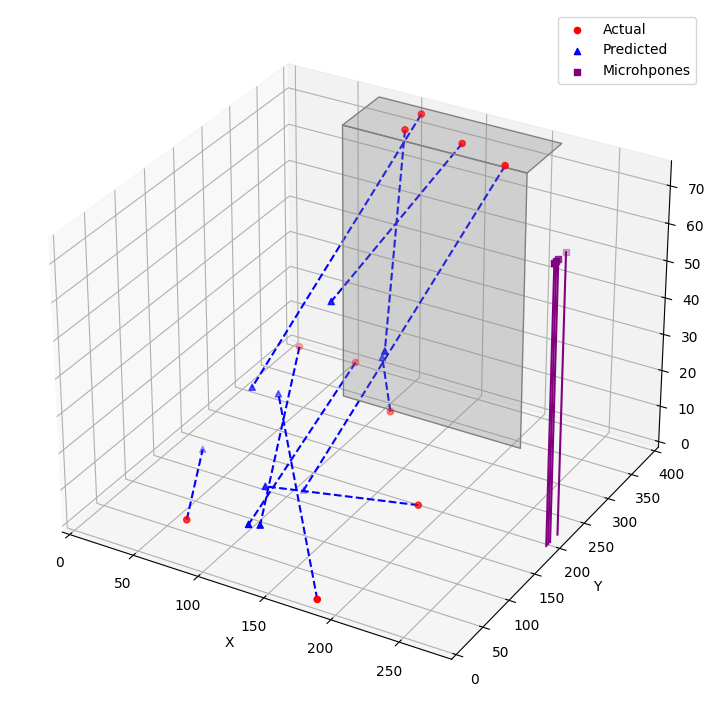

-----------
Actual: (109, 327, 0)
Predicted [134.52584838867188, 247.0849151611328, 28.132280349731445]
-----------
Actual: (190, 340, 74)
Predicted [93.62518310546875, 196.27203369140625, -6.706451892852783]
-----------
Actual: (61, 60, 0)
Predicted [27.546157836914062, 163.9690704345703, 1.963731288909912]
-----------
Actual: (150, 360, 74)
Predicted [104.36454772949219, 224.72671508789062, 43.083984375]
-----------
Actual: (8, 392, 0)
Predicted [108.40042877197266, 82.29740905761719, 0.8278508186340332]
-----------
Actual: (184, 6, 0)
Predicted [74.3158950805664, 196.76206970214844, 18.23699378967285]
-----------
Actual: (105, 395, 74)
Predicted [63.59853744506836, 174.09889221191406, 21.828474044799805]
-----------
Actual: (185, 191, 0)
Predicted [96.23431396484375, 120.40066528320312, 4.968712329864502]
-----------
Actual: (54, 393, 0)
Predicted [101.54936981201172, 77.38639831542969, 0.9056816101074219]
-----------
Actual: (107, 358, 74)
Predicted [147.72434997558594, 219.0745544

In [ ]:
k_idx = give_kinects_index(k1=False, k2=True)
print('Number of Training Samples:', len(X_train[0]))
print('Number of Test Samples:', len(y_test))
print('Input Shapes:', [inp_gcc, inp_ps])
print('Method: Results for Two parallel CNNs with power spectrums and cross correlations as inputs. Only K2.')
print(f'Predicted: x:{True}, y:{True}, z:{True}')
print('K1 samples used:', False, '\nK2 samples used:', True)
print('Number of Possible Epochs: 500, Early Stopping Patience: 100. Stopped after 108 epochs.')
print('Model Summary:')
cur_model.summary()
print('\n\n\n')

print('Results for model predictions:\n', means_pred)

unique_lbls = extract_unique_lists(y_test)
plot_points(unique_lbls, predictions, pred_dict, k_idx, has_z=True)

for pos, pred in pred_dict.items():
    print('-----------')
    print('Actual:', pos)
    print('Predicted', pred)